In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ML & Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve, classification_report
from imblearn.over_sampling import SMOTE

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Explainability
import shap

# Load cleaned data
df = pd.read_csv("Cleaned_Employee_Attrition.csv")

# Target and features
X = df.drop("Attrition", axis=1)
y = df["Attrition"]


C:\Users\himan\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Train-Test Split

In [5]:

X['AgeGroup'] = X['AgeGroup'].astype('category').cat.codes
X['TenureBucket'] = X['TenureBucket'].astype('category').cat.codes

# Split into training and testing sets (80-20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

### Handle Class Imbalance (SMOTE)

In [6]:
from imblearn.over_sampling import SMOTE

# Scale numeric features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply SMOTE to balance classes
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)

# Check new balance
print(pd.Series(y_train_res).value_counts())

Attrition
0    986
1    986
Name: count, dtype: int64


### Train ML Models

#### Logistic Regression

In [7]:
lr = LogisticRegression()
lr.fit(X_train_res, y_train_res)
y_pred_lr = lr.predict(X_test_scaled)

#### Random Forest

In [8]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_res, y_train_res)
y_pred_rf = rf.predict(X_test_scaled)

####  XGBoost

In [9]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train_res, y_train_res)
y_pred_xgb = xgb.predict(X_test_scaled)

C:\Users\himan\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:34:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


### Evaluation Metrics

In [10]:
def evaluate_model(y_test, y_pred, model_name):
    print(f"--- {model_name} ---")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("-" * 50)

#### Evaluate

In [11]:
evaluate_model(y_test, y_pred_lr, "Logistic Regression")

--- Logistic Regression ---
Accuracy: 0.7857142857142857
Precision: 0.3918918918918919
Recall: 0.6170212765957447
F1 Score: 0.4793388429752066
Confusion Matrix:
 [[202  45]
 [ 18  29]]
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.82      0.87       247
           1       0.39      0.62      0.48        47

    accuracy                           0.79       294
   macro avg       0.66      0.72      0.67       294
weighted avg       0.83      0.79      0.80       294

--------------------------------------------------


In [12]:
evaluate_model(y_test, y_pred_rf, "Random Forest")

--- Random Forest ---
Accuracy: 0.8231292517006803
Precision: 0.3684210526315789
Recall: 0.14893617021276595
F1 Score: 0.21212121212121213
Confusion Matrix:
 [[235  12]
 [ 40   7]]
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.95      0.90       247
           1       0.37      0.15      0.21        47

    accuracy                           0.82       294
   macro avg       0.61      0.55      0.56       294
weighted avg       0.78      0.82      0.79       294

--------------------------------------------------


In [13]:
evaluate_model(y_test, y_pred_xgb, "XGBoost")

--- XGBoost ---
Accuracy: 0.8639455782312925
Precision: 0.6521739130434783
Recall: 0.3191489361702128
F1 Score: 0.42857142857142855
Confusion Matrix:
 [[239   8]
 [ 32  15]]
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.97      0.92       247
           1       0.65      0.32      0.43        47

    accuracy                           0.86       294
   macro avg       0.77      0.64      0.68       294
weighted avg       0.85      0.86      0.84       294

--------------------------------------------------


### ROC-AUC Curve

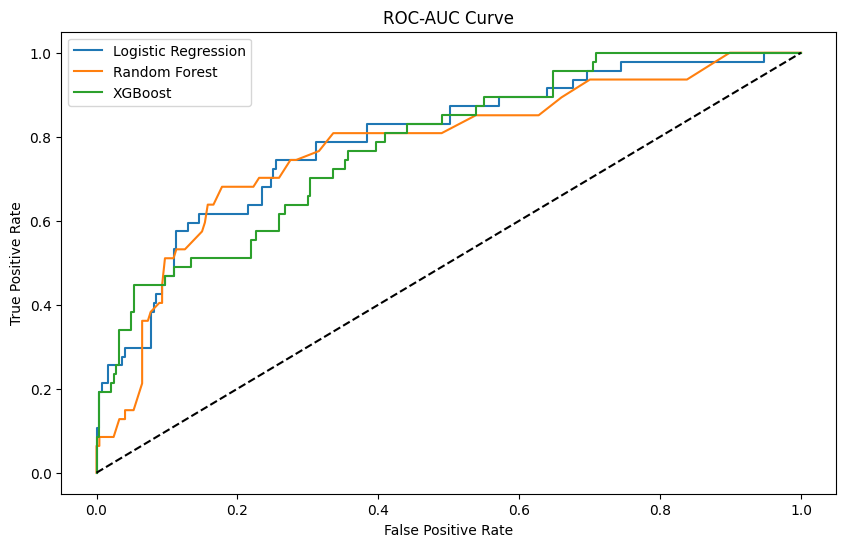

In [37]:
# Predict probabilities
y_proba_lr = lr.predict_proba(X_test_scaled)[:, 1]
y_proba_rf = rf.predict_proba(X_test_scaled)[:, 1]
y_proba_xgb = xgb.predict_proba(X_test_scaled)[:, 1]

# Plot ROC curve
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb)

plt.figure(figsize=(10, 6))
plt.plot(fpr_lr, tpr_lr, label='Logistic Regression')
plt.plot(fpr_rf, tpr_rf, label='Random Forest')
plt.plot(fpr_xgb, tpr_xgb, label='XGBoost')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC-AUC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

### Feature Importance

#### For Random Forest

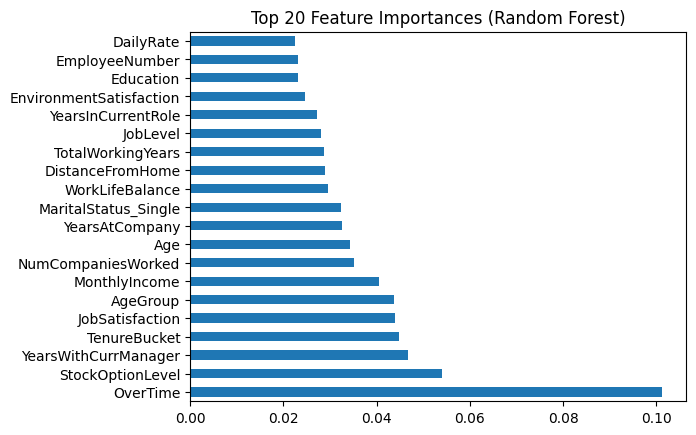

In [38]:
importances_rf = pd.Series(rf.feature_importances_, index=X.columns)
importances_rf.nlargest(20).plot(kind='barh')
plt.title("Top 20 Feature Importances (Random Forest)")
plt.show()

#### For XGBoost

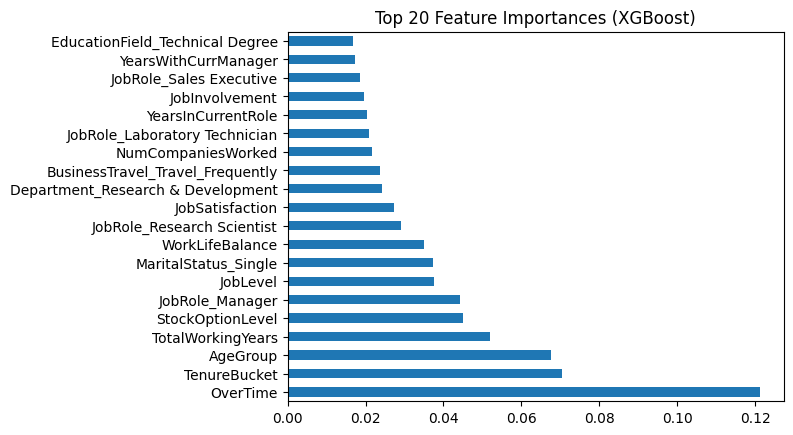

In [39]:
importances_xgb = pd.Series(xgb.feature_importances_, index=X.columns)
importances_xgb.nlargest(20).plot(kind='barh')
plt.title("Top 20 Feature Importances (XGBoost)")
plt.show()

### Explainability using SHAP

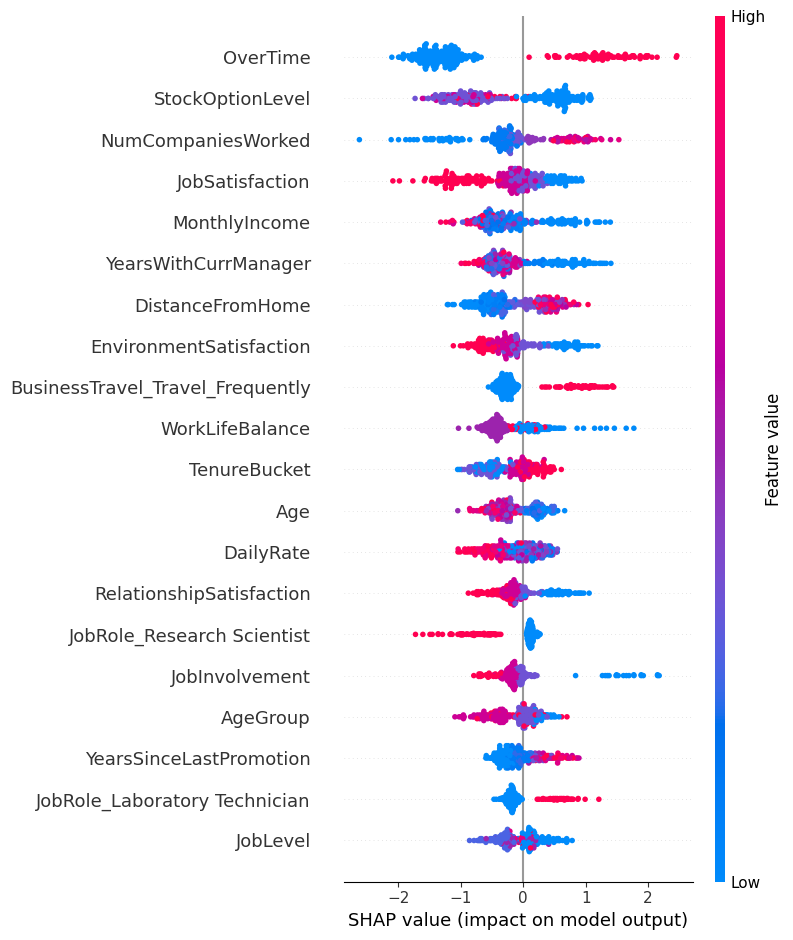

In [40]:
# Initialize SHAP explainer
explainer = shap.Explainer(xgb)
shap_values = explainer(X_test_scaled)

# SHAP summary plot
shap.summary_plot(shap_values, features=X_test, feature_names=X.columns)

## SVM - Support Vector Machine

In [21]:
from sklearn.svm import SVC

# Initialize SVM with probability=True to enable ROC-AUC analysis
svm = SVC(probability=True, kernel='rbf', C=1.0, random_state=42)

# Train on resampled (SMOTE) & scaled data
svm.fit(X_train_res, y_train_res)

# Predict
y_pred_svm = svm.predict(X_test_scaled)

In [22]:
y_pred_svm

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0])

### Evaluate SVM Performance

In [16]:
evaluate_model(y_test, y_pred_svm, "Support Vector Machine")

--- Support Vector Machine ---
Accuracy: 0.8401360544217688
Precision: 0.5
Recall: 0.40425531914893614
F1 Score: 0.4470588235294118
Confusion Matrix:
 [[228  19]
 [ 28  19]]
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.92      0.91       247
           1       0.50      0.40      0.45        47

    accuracy                           0.84       294
   macro avg       0.70      0.66      0.68       294
weighted avg       0.83      0.84      0.83       294

--------------------------------------------------


### ROC-AUC Curve for SVM

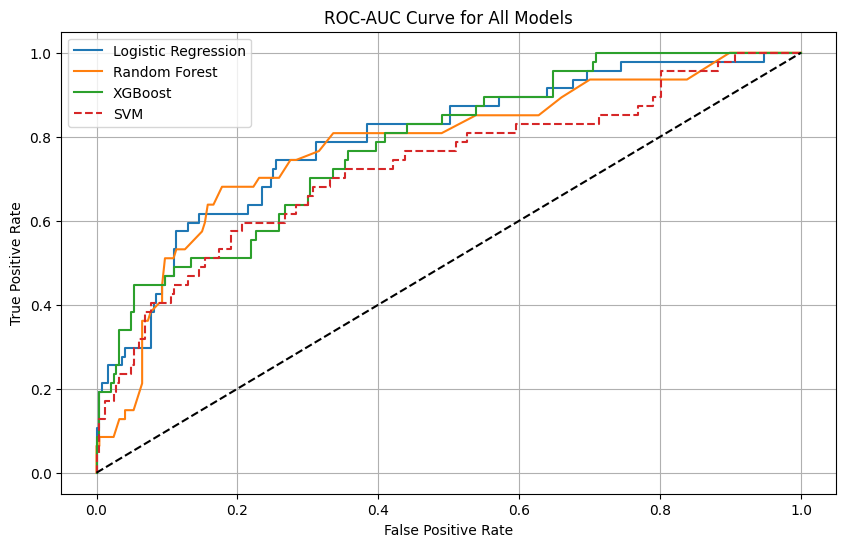

In [44]:
from sklearn.metrics import roc_curve, auc

# Predict probabilities for ROC
y_proba_svm = svm.predict_proba(X_test_scaled)[:, 1]
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_proba_svm)

# Plot ROC with other models
plt.figure(figsize=(10, 6))
plt.plot(fpr_lr, tpr_lr, label='Logistic Regression')
plt.plot(fpr_rf, tpr_rf, label='Random Forest')
plt.plot(fpr_xgb, tpr_xgb, label='XGBoost')
plt.plot(fpr_svm, tpr_svm, label='SVM', linestyle='--')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC-AUC Curve for All Models')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.legend()
plt.show()

## Artificial Neural Network (ANN) – Employee Attrition Modeling

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Previously scaled and SMOTE-balanced data:
# X_train_res, y_train_res, X_test_scaled, y_test

C:\Users\himan\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
C:\Users\himan\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
C:\Users\himan\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framewo

###  Build ANN Architecture

In [27]:
model = Sequential()

# Input layer
model.add(Dense(64, input_dim=X_train_res.shape[1], activation='relu'))

# Hidden layers
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(16, activation='relu'))

# Output layer
model.add(Dense(1, activation='sigmoid'))  # Binary classification


C:\Users\himan\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Compile the Model

In [28]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

### Train the Model

In [29]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=5, restore_best_weights=True)

history = model.fit(
    X_train_res, y_train_res,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.7039 - loss: 0.5928 - val_accuracy: 0.6709 - val_loss: 0.6395
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8066 - loss: 0.4567 - val_accuracy: 0.7772 - val_loss: 0.4879
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8263 - loss: 0.3937 - val_accuracy: 0.7519 - val_loss: 0.5378
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8656 - loss: 0.3400 - val_accuracy: 0.7797 - val_loss: 0.4851
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8738 - loss: 0.3042 - val_accuracy: 0.8228 - val_loss: 0.3610
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8814 - loss: 0.2822 - val_accuracy: 0.8430 - val_loss: 0.3373
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9011 - loss: 0.2513 - val_accuracy: 0.8608 - val_loss: 0.3118
Epoch 8/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9093 - loss: 0.2321 - val_accuracy: 0.

### Plot Training History

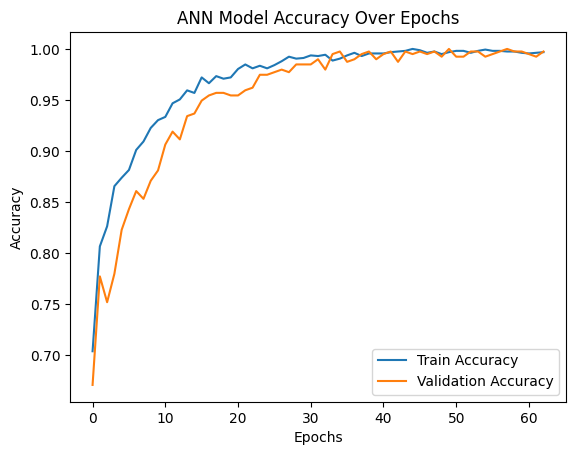

In [30]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('ANN Model Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Evaluate the Model

In [31]:
y_pred_ann = (model.predict(X_test_scaled) > 0.5).astype("int32")

from sklearn.metrics import classification_report, confusion_matrix

print(confusion_matrix(y_test, y_pred_ann))
print(classification_report(y_test, y_pred_ann))

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step 
[[223  24]
 [ 30  17]]
              precision    recall  f1-score   support

           0       0.88      0.90      0.89       247
           1       0.41      0.36      0.39        47

    accuracy                           0.82       294
   macro avg       0.65      0.63      0.64       294
weighted avg       0.81      0.82      0.81       294



In [32]:
evaluate_model(y_test, y_pred_ann, "Artificial Neural Network")

--- Artificial Neural Network ---
Accuracy: 0.8163265306122449
Precision: 0.4146341463414634
Recall: 0.3617021276595745
F1 Score: 0.38636363636363635
Confusion Matrix:
 [[223  24]
 [ 30  17]]
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.90      0.89       247
           1       0.41      0.36      0.39        47

    accuracy                           0.82       294
   macro avg       0.65      0.63      0.64       294
weighted avg       0.81      0.82      0.81       294

--------------------------------------------------


###  ROC Curve for ANN

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


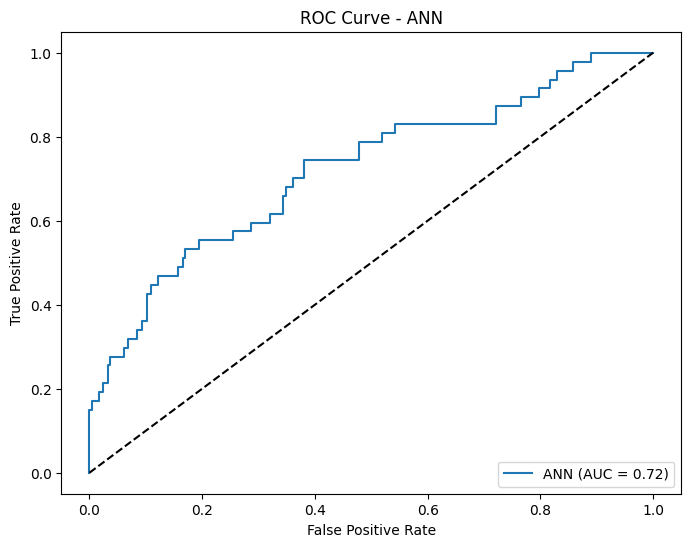

In [34]:
from sklearn.metrics import roc_curve, auc

y_proba_ann = model.predict(X_test_scaled).ravel()
fpr_ann, tpr_ann, _ = roc_curve(y_test, y_proba_ann)
roc_auc_ann = auc(fpr_ann, tpr_ann)

plt.figure(figsize=(8,6))
plt.plot(fpr_ann, tpr_ann, label='ANN (AUC = %0.2f)' % roc_auc_ann)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - ANN")
plt.legend(loc="lower right")
plt.show()

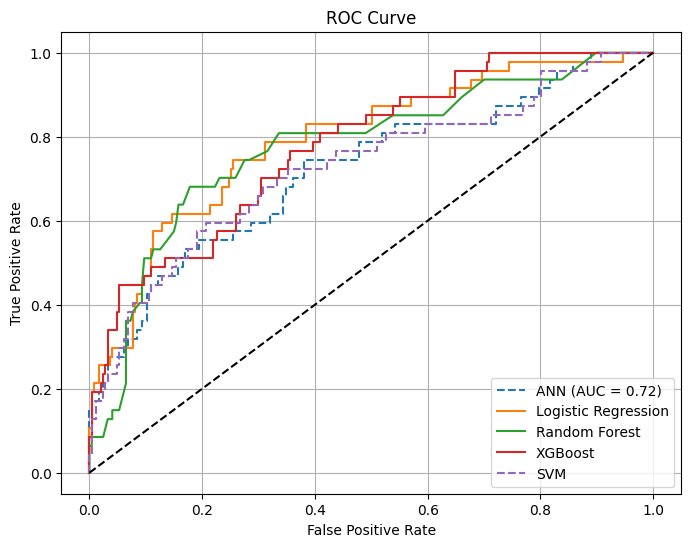

In [45]:
plt.figure(figsize=(8,6))
plt.plot(fpr_ann, tpr_ann, label='ANN (AUC = %0.2f)' % roc_auc_ann, linestyle='--')
plt.plot(fpr_lr, tpr_lr, label='Logistic Regression')
plt.plot(fpr_rf, tpr_rf, label='Random Forest')
plt.plot(fpr_xgb, tpr_xgb, label='XGBoost')
plt.plot(fpr_svm, tpr_svm, label='SVM', linestyle='--')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

### Explainability with SHAP for ANN

PermutationExplainer explainer: 101it [01:02,  1.60it/s]                                                               
C:\Users\himan\AppData\Local\Temp\ipykernel_23912\1800302795.py:5: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, features=X_test.iloc[:100], feature_names=X.columns)


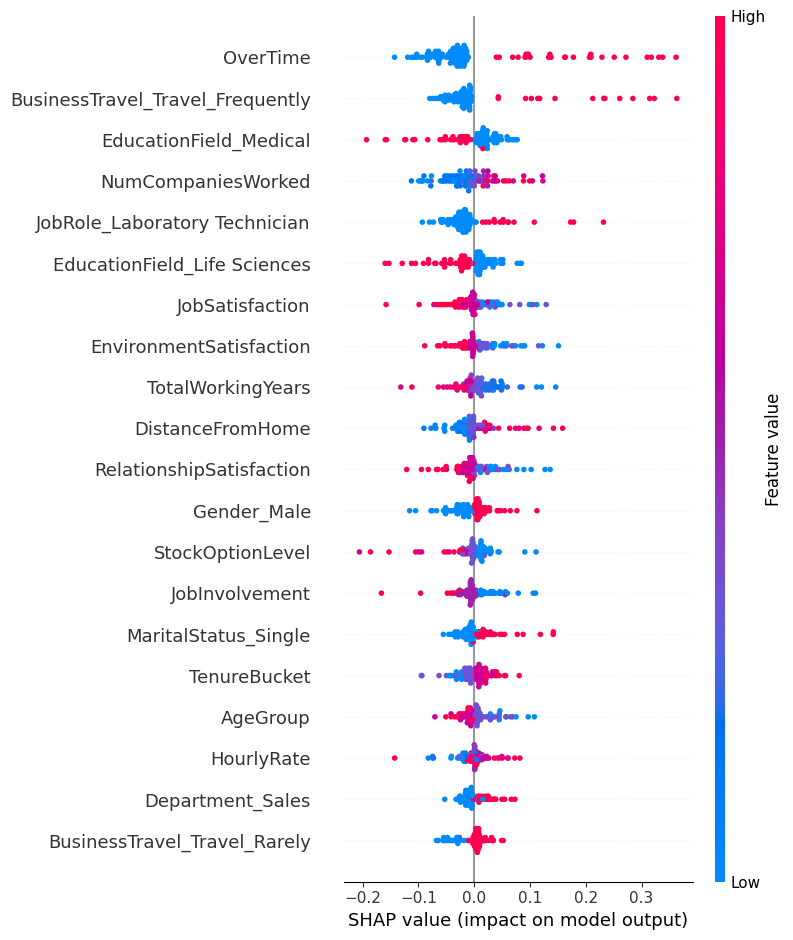

In [25]:
explainer = shap.Explainer(model, X_train_scaled[:100])
shap_values = explainer(X_test_scaled[:100])

# Summary plot
shap.summary_plot(shap_values, features=X_test.iloc[:100], feature_names=X.columns)